## Task Description

See attached for the file ‘Data.csv.xlsx’ which contains total return time series data for a number of markets. You are asked to use this total return information to generate a back test of a trading strategy proposed by you within that universe. 
 

Preferred Programming language Python (Python)
Trading frequency: no restrictions
Leverage: no restrictions
Trading cost: fixed 10 basis points (0.1%) for all assets
 
Output format
1.	Performance statistics
2.	Relevant charts
3.	Underlying code
4.	Additional info (if applicable)

## Summary

Given 18 assets across equity, fixed income and forex, I examined the correlation and propose to apply pairs trading on 4 highly correlated assets. I have run the back testing against different sigma, and also conducted market research to analyze the correlation(cointegration) between the trading pairs. In the end, I will summary my view on this strategy.

## Content
1. Data Preperation


2. Pre-trading analysis  
    2.1 Statistics by asset class
        2.1.1 Equity Market
        2.1.2 Fixed Market
        2.1.3 Forex Market
     2.2 Correlation Analysis    


3. Pairs Trading Strategy   
    
    3.1 Test cointegration   
    3.2 Signal Processing   
    3.3 Visualize Result    
    3.4 Generate Measure Matrix   


4. Risk Evaluation    
    
    4.1 Risk against Different Sigma    
    4.2 Risk Ratios    
    4.3 Risk from Macro Events    
    



# 1. Data Preperation

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import statsmodels.api as sm
import warnings
from pandas.core.common import SettingWithCopyWarning

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()
    
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
df = pd.read_csv('Data.csv')

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date',inplace = True)
df = df.sort_index(ascending=True)

In [4]:
#df.isnull().sum()

In [5]:
# Calculate Total investment return for each asset, then times 100, so that all data is percentage(%)
return_df = df.pct_change(1)*100

In [6]:
#  Define risk-return scartter plot
def scartter_plot(asset_class):
    df_asset = return_df.filter(like=asset_class).describe()
    df_asset = df_asset.transpose()

    plt.figure(figsize=(7,7))
    plt.plot(df_asset['mean'], df_asset['std'],'ro',label = df_asset.index )
    plt.title('Global {} Market- Risk vs. Return'.format(asset_class)) 

    for i in range(0,df_asset.shape[0]):
        plt.annotate(
                        df_asset.index[i],
                       (df_asset['mean'][i],df_asset['std'][i])
                       )

    plt.xticks(rotation=45)
    plt.xlabel('Total Investment Return(%)(mean)')
    plt.ylabel('Risk(std)')

# 2. Pre-trade analysis

## 2.1  Statistics by asset class

### 2.1.1 Equity Market

In [7]:
#created EQ_bm as the avergae of total investment of all equity assets in the universe. 
df['EQ_bm'] = df.filter(like='EQ').mean(axis = 1)

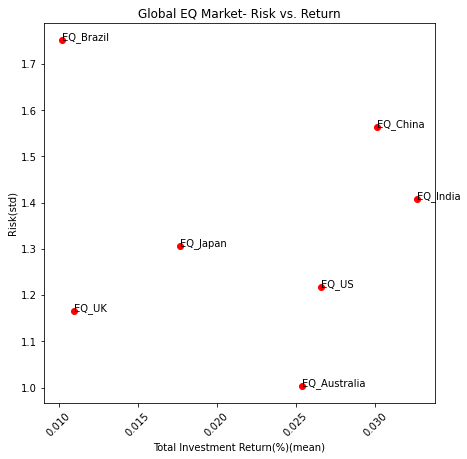

In [8]:
#  risk-return scartter plot
scartter_plot("EQ")

Text(0, 0.5, 'Total Investment')

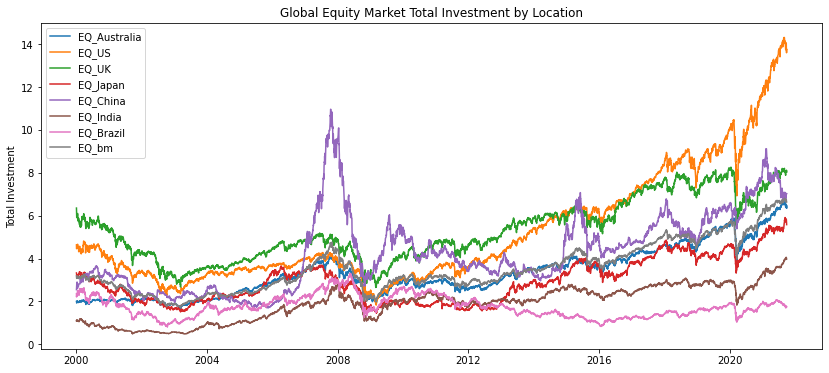

In [9]:
plt.figure(figsize=(14,6))
plt.plot(df.filter(like='EQ'),label = df.filter(like='EQ').columns)

plt.title('Global Equity Market Total Investment by Location') 
plt.legend()
plt.ylabel('Total Investment')

Overall, the equity market has been very volatile. The global equity market has increased ~200% from 2003 to 2008, and crashed in 2008. There is a steady increase after 2008. However, the market bounced after the 2020 pandemic crash and continued towards an upwards trajectory. The discrepancy between each economy becomes larger and larger after 2012. Before 2016, the UK remained first place in value of total investment. US equity market took over and increased quickly after 2016. China's equity market seems abnormally bullish in 2007-2008. Brazilian equity market flated out after the 2008 financial crisis, while India increased steadily. Australia's performance is well synchronized with the average market performance.

### 2.1.2 Fixed Income

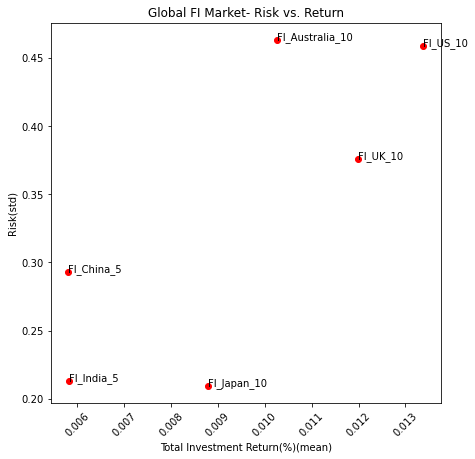

In [10]:
#  risk-return scartter plot
scartter_plot("FI")

Text(0, 0.5, 'Total Investment')

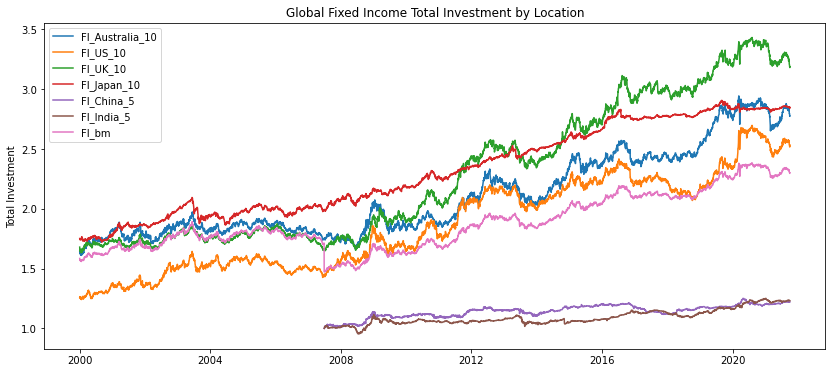

In [11]:
#created FI_bm as the avergae of total investment of all equity assets in the universe. 
df['FI_bm'] = df.filter(like='FI').mean(axis = 1)

plt.figure(figsize=(14,6))
plt.plot(df.filter(like='FI'),label = df.filter(like='FI').columns)

plt.title('Global Fixed Income Total Investment by Location') 
plt.legend()
plt.ylabel('Total Investment')

Overall, the fixed income market has been steadily increasing. The UK market has been undergoing a higher average total investment compared to the other countries. The Japanese market has flattened throughout the observation window with little fluctuation, in comparison to other markets. Noticeably, the movement of Australia, the UK, and the US are similar. A key point is the lack of historical data for both Chinese and Indian data set from ~2000 to ~2007. The Chinese and the Indian market also show a low value of the total investment.

### 2.1.3 Forex Market

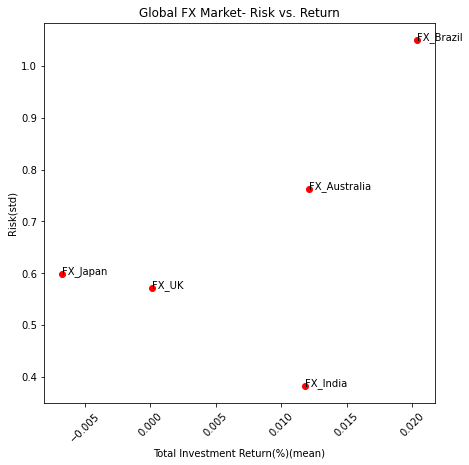

In [12]:
#  risk-return scartter plot
scartter_plot("FX")

Text(0, 0.5, 'Total Investment')

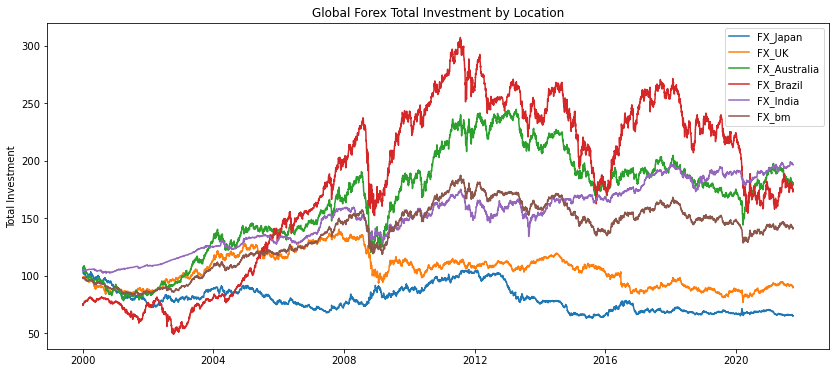

In [13]:
# FX_bm:avergae of total investment of all Forex market
df['FX_bm'] = df.filter(like='FX').mean(axis = 1)

plt.figure(figsize=(14,6))
plt.plot(df.filter(like='FX'),label = df.filter(like='FX').columns)

plt.title('Global Forex Total Investment by Location') 
plt.legend()
plt.ylabel('Total Investment')

The forex market performs differently across countries. The relatively stable markets are Japan, India and the UK, while the volatile markets are Brazil and Australia. There are fewer distinct correlations between the price of the forex assets, in comparison to the fixed income market.

## 2.2 Correlation Analysis

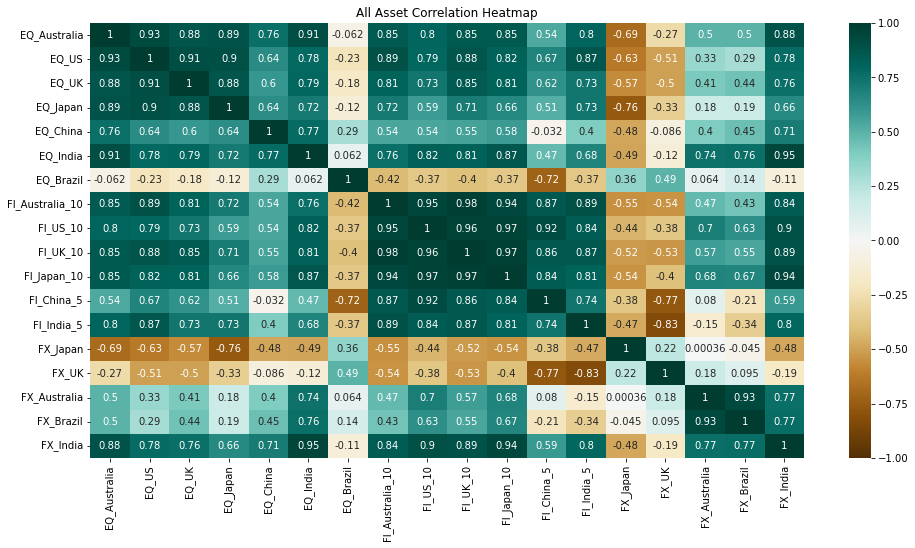

In [14]:
plt.figure(figsize=(16, 8))
heatmap = sns.heatmap(df.drop(columns=['EQ_bm','FI_bm','FX_bm']).corr(),vmin=-1, vmax=1, annot=True,cmap='BrBG')
heatmap.set_title('All Asset Correlation Heatmap');

From the heatmap above, we can see that assets in fixed income have a strong correlation with each other, meaning that the total investment in the fixed income market tends to move in the same direction. The returns on these assets are homogeneous. 
However, Japan and UK's forex show a strong negative correlation with other fixed income assets.

In [15]:
min_score = 0.95

def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, min_score =.95):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[au_corr>min_score ]

In [16]:
get_top_abs_correlations(df.drop(columns=['EQ_bm','FI_bm','FX_bm']), min_score =.95)

FI_Australia_10  FI_UK_10       0.980548
FI_UK_10         FI_Japan_10    0.973325
FI_US_10         FI_Japan_10    0.967420
                 FI_UK_10       0.963876
dtype: float64

In [17]:
all_pairs = (
    ('FI_Australia_10',  'FI_UK_10') ,      

    ('FI_UK_10',         'FI_Japan_10')  , 

   ('FI_US_10',         'FI_Japan_10')   ,

   ('FI_US_10',         'FI_UK_10')      
)

# 3.  Pairs Trading Strategy

Pairs trading strategy will manage to find a pair of highly correlated assets. Theoretically, as long as the correlation exists, the two assets should move in a similar direction.

In this back testing program, we will run a test first to ensure the cointegration relation exists.
Then, we set the trigger condition for both assets. when one is getting too bullish, we short the bullish one and long the bearish one, and vice versa.
Next, we compute the current standardized residual of the selected asset accordingly. When the standardized residual exceeds the threshold, it generates the trading signal. 
Finally, we calculate the measurement matrix and review portfolio performance.

We will assume an initial capital of  40,000 dollars to be spent on the trading of each pair, and a total of 160,000 dollars for the initial capital.

We also assume the trading cost is 0.1%.

In [18]:
# set up basis(trading cost) for all assets
basis=0.001

## 3.1 Test Cointegration: Engle-Granger two-step method

The Engle-Granger Two-Step method starts by creating residuals based on the static regression and then testing the residuals for the presence of unit roots. It uses the Augmented Dickey-Fuller Test (ADF) or other tests to test for stationarity units in time series. If the time series are cointegrated, the Engle-Granger method will show the stationarity of the residuals.

In [19]:
def EG_method(X,Y,show_summary=False):
    
    #step 1
    #apply DOLS method to test whether the there is a long run equilibrium(residual) exists
    model1=sm.OLS(Y,sm.add_constant(X)).fit()
    epsilon=model1.resid #z stats is the spread and should be stationary if X and Y are cointegrated
    
    if show_summary:
        print('\nStep 1\n')
        print(model1.summary())
    
    #Perform Augmented Dickey–Fuller test 
    #Null hypothesis : a unit root is present in an autoregressive time series model
    #check p value of ADF test:if p <= 5%, stationary test is passed
    if sm.tsa.stattools.adfuller(epsilon)[1]>0.05:
        return False,model1
    
    #take first order difference of X and Y plus the lagged residual from step 1
    X_dif=sm.add_constant(pd.concat([X.diff(),epsilon.shift(1)],axis=1).dropna())
    Y_dif=Y.diff().dropna()        
    
    #step 2
    #estimate error correction model
    model2=sm.OLS(Y_dif,X_dif).fit()
    
    if show_summary:
        print('\nStep 2\n')
        print(model2.summary())
    
    #adjustment coefficient must be negative
    if list(model2.params)[-1]>0:
        return False,model1
    else:
        return True,model1

## 3.2 Signal Processing

First, we verify the status of cointegration by checking historical datasets.
Bandwidth determines the number of data points for consideration. Bandwidth is 250 by default, around one year's data points. If the status is valid, we check the signals.When z stat gets above the upper bound,we long the bearish one and short the bullish one, and vice versa.

In [20]:
def signal_generation(asset1,asset2,method,sigma,bandwidth=250):    
    
    signals=pd.DataFrame()
       
    signals['asset1']=asset1
    signals['asset2']=asset2
    
    #signals only imply holding
    signals['signals1']=0    
    signals['signals2']=0
    
    #initialize
    prev_status=False
    signals['z']=np.nan
    signals['z upper limit']=np.nan
    signals['z lower limit']=np.nan
    signals['fitted']=np.nan    
    signals['residual']=np.nan
    
    #signal processing
    for i in range(bandwidth,len(signals)):
        
        #cointegration test
        coint_status,model=method(signals['asset1'].iloc[i-bandwidth:i],
                                  signals['asset2'].iloc[i-bandwidth:i])
                
        #cointegration breaks
        #clear existing positions
        if prev_status and not coint_status:           
            if signals.at[signals.index[i-1],'signals1']!=0:
                signals.at[signals.index[i],'signals1']=0
                signals.at[signals.index[i],'signals2']=0
                signals['z'].iloc[i:]=np.nan
                signals['z upper limit'].iloc[i:]=np.nan
                signals['z lower limit'].iloc[i:]=np.nan
                signals['fitted'].iloc[i:]=np.nan    
                signals['residual'].iloc[i:]=np.nan
        
        #cointegration starts
        #set the trigger conditions
        if not prev_status and coint_status:
            
            #predict the price to compute the residual       
            signals['fitted'].iloc[i:]=model.predict(sm.add_constant(signals['asset1'].iloc[i:]))
            signals['residual'].iloc[i:]=signals['asset2'].iloc[i:]-signals['fitted'].iloc[i:]
            
            #normalize the residual to get z stats
            #z should be a white noise following N(0,1)
            signals['z'].iloc[i:]=(signals['residual'].iloc[i:]-np.mean(model.resid))/np.std(model.resid)
                        
            #create thresholds
            #conventionally one sigma is the threshold
            #two sigma reaches 95% which is relatively difficult to trigger
            signals['z upper limit'].iloc[i:]=signals['z'].iloc[i]+sigma*np.std(model.resid)
            signals['z lower limit'].iloc[i:]=signals['z'].iloc[i]-sigma*np.std(model.resid)
        
        #as z stat cannot exceed both upper and lower bounds at the same time,the lines below hold
        if coint_status and signals['z'].iloc[i]>signals['z upper limit'].iloc[i]:            
             signals.at[signals.index[i],'signals1']=1            
        if coint_status and signals['z'].iloc[i]<signals['z lower limit'].iloc[i]:            
             signals.at[signals.index[i],'signals1']=-1
                
        prev_status=coint_status    
    
    #signals only imply holding
    #we take the first order difference to obtain the execution signal
    signals['positions1']=signals['signals1'].diff()
    
    #only need to generate trading signal of one asset
    #the other one should be the opposite direction
    signals['signals2']=-signals['signals1']
    signals['positions2']=signals['signals2'].diff()   
    
    return signals

## 3.3 Visualize Result

In [21]:
#position visualization
def plot(data,ticker1,ticker2):    
   
    fig=plt.figure(figsize=(16,8))
    bx=fig.add_subplot(111)   
    bx2=bx.twinx()
    
    #viz two different assets
    asset1_price,=bx.plot(data.index,data['asset1'],
                          c='#113aac',alpha=0.7)
    asset2_price,=bx2.plot(data.index,data['asset2'],
                          c='#907163',alpha=0.7)

    #viz positions
    asset1_long,=bx.plot(data.loc[data['positions1']==1].index,
                data['asset1'][data['positions1']==1],
                lw=0,marker='^',markersize=8,
                c='g',alpha=0.7)
    asset1_short,=bx.plot(data.loc[data['positions1']==-1].index,
                data['asset1'][data['positions1']==-1],
                lw=0,marker='v',markersize=8,
                c='r',alpha=0.7)
    asset2_long,=bx2.plot(data.loc[data['positions2']==1].index,
                 data['asset2'][data['positions2']==1],
                 lw=0,marker='^',markersize=8,
                 c='g',alpha=0.7)
    asset2_short,=bx2.plot(data.loc[data['positions2']==-1].index,
                 data['asset2'][data['positions2']==-1],
                 lw=0,marker='v',markersize=8,
                 c='r',alpha=0.7)

    #set labels
    bx.set_ylabel(ticker1,)
    bx2.set_ylabel(ticker2,rotation=270)
    bx.yaxis.labelpad=15
    bx2.yaxis.labelpad=15
    bx.set_xlabel('Date')
    bx.xaxis.labelpad=15

    plt.legend([asset1_price,asset2_price,asset1_long,asset1_short],
               [ticker1,ticker2,
               'LONG','SHORT'],
               loc='lower left')

    plt.title('Pair Trading: {} and {}'.format(ticker1, ticker2))
    #plt.xlabel('Date')
    plt.grid(True)
    plt.show()

In [22]:
#visualize overall portfolio performance
def portfolio(data,x,y,sigma):

    #initial capital to calculate the actual pnl
    capital0=20000

    #shares to buy of each position
    #this is no forward bias
    #just ensure we have enough €€€ to purchase shares when the price peaks
    positions1=capital0//max(data['asset1'])
    positions2=capital0//max(data['asset2'])

    #cumsum1 column is created to check the holding of the position
    data['cumsum1']=data['positions1'].cumsum()

    #since there are two assets, we calculate each asset separately
    #in the end we aggregate them into one portfolio
    portfolio=pd.DataFrame()
    
    portfolio['asset1']=data['asset1']
    portfolio['holdings1']=data['cumsum1']*data['asset1']*positions1
    portfolio['cash1']=capital0-(data['positions1']*data['asset1']*positions1*(1+basis)).cumsum()
   
    portfolio['total asset1']=portfolio['holdings1']+portfolio['cash1']
    portfolio['return1']=portfolio['total asset1'].pct_change()
    portfolio['positions1']=data['positions1']
    
    data['cumsum2']=data['positions2'].cumsum()
    portfolio['asset2']=data['asset2']
    portfolio['holdings2']=data['cumsum2']*data['asset2']*positions2
    portfolio['cash2']=capital0-(data['positions2']*data['asset2']*positions2*(1+basis)).cumsum()
    portfolio['total asset2']=portfolio['holdings2']+portfolio['cash2']
    portfolio['return2']=portfolio['total asset2'].pct_change()
    portfolio['positions2']=data['positions2']
 
    portfolio['z']=data['z']
    portfolio['total asset']=portfolio['total asset1']+portfolio['total asset2']
        
    portfolio['z upper limit']=data['z upper limit']
    portfolio['z lower limit']=data['z lower limit']
    
    #big_portfolio['{},{}'.format(x,y)] = portfolio['total asset']
    
    #plotting the asset value change of the portfolio
    fig=plt.figure(figsize=(16,8))
    ax=fig.add_subplot(111)
    ax2=ax.twinx()
 
    total_asset_performance,=ax.plot(portfolio['total asset'],c='#46344e')
    z_stats,=ax2.plot(portfolio['z'],c='#4f4a41',alpha=0.2)
 
    threshold=ax2.fill_between(portfolio.index,portfolio['z upper limit'],
                       portfolio['z lower limit'],
                       alpha=0.2,color='#ffb48f')
     
    #due to the opposite direction of trade for 2 assets
    #we will not plot positions on asset performance    
    ax.set_ylabel('Asset Value')
    ax2.set_ylabel('Z Statistics',rotation=270)
    ax.yaxis.labelpad=15
    ax2.yaxis.labelpad=15
    ax.set_xlabel('Date')
    ax.xaxis.labelpad=15
    
    plt.legend([z_stats,threshold,total_asset_performance],
               ['Z Statistics', 'Z Statistics +-{} Sigma'.format(sigma),
                'Total Investment'],loc='best')

    plt.grid(True)   
    plt.title('Total Investment: {} and {}'.format(x, y))
    plt.show()
    
    portfolio.to_csv('trade_result_{}_and_{}.csv'.format(x,y))

    return portfolio

## 3.4 Generate Measure Matrix 

In [23]:
def measure_matrix(ticker1,ticker2,portfolio,risk_free_rate):
       
    ROA = 1- 20000*2/portfolio['total asset'].iloc[-1]
    sharpe_ratio = ROA -risk_free_rate
    MDD = portfolio['total asset'].max()-portfolio['total asset'].min()
    
    new_measures = {'Asset 1':ticker1,
                      'Asset 2':ticker2,
                      'ROA':ROA, 
                      'Sharpe Ratio':sharpe_ratio, 
                      'MDD':MDD}
    
    new_matrix_row = pd.DataFrame(columns=['Asset 1','Asset 2','ROA','Sharpe Ratio','MDD'])
    new_matrix_row = new_matrix_row.append(new_measures,ignore_index=True)
       
    return new_matrix_row

In [24]:
def main(x,y,sigma):
    
    # select back testing window: yyyy-mm-dd
    start = '2016-11-09'
    end   = df.index.max()
    
    asset1 = df[start:end][x]
    asset2 = df[start:end][y]
   
    ticker1= x
    ticker2= y
    
    #use Fix Income US as a US bond risk free rate. Which is ~1% p.a.
    risk_free_rate = (df.loc[end]['FI_US_10']-df.loc[start]['FI_US_10'])**(360/len(df[start:end]))-1
    
    #create signals
    signals = signal_generation(asset1,asset2,EG_method,sigma)

    #only viz the part where trading signals occur
    ind=signals['z'].dropna().index[0]

    #viz positions
    plot(signals[ind:],ticker1,ticker2)    

    #viz portfolio performance
    #portfolio_details=portfolio(signals[ind:],x,y,sigma)
    portfolio_details=portfolio(signals,x,y,sigma)
    big_portfolio['{},{}'.format(x,y)] = portfolio_details['total asset']
    
    #generate measure matrix
    m_matrix = measure_matrix(ticker1,ticker2,portfolio_details,risk_free_rate)
    pairs_total_investment = portfolio_details['total asset']
    
    return  m_matrix

# 4. Risk Evaluation

## 4.1 Risk against Different Sigma

Sigma is a statistical measurement of variability, showing how much variation exists from a statistical average.
Three-sigma limit is a statistical calculation where the data are within three standard deviations from a mean. 
In this section, we will run the back testing against 1, 2, and 3 sigmas.

In [25]:
# sigma_df stores total investment against different sigma
sigma_df = pd.DataFrame()

### 4.1.1 One Sigma Testing

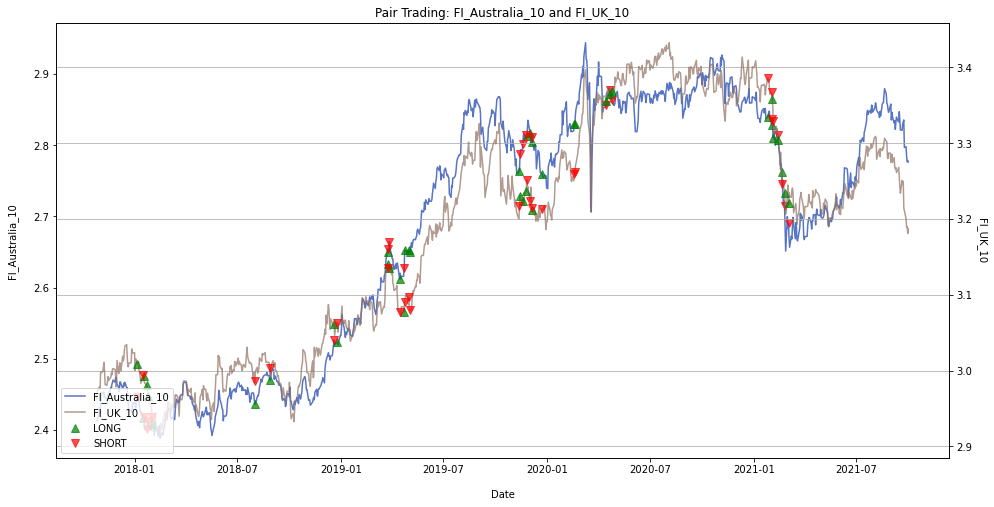

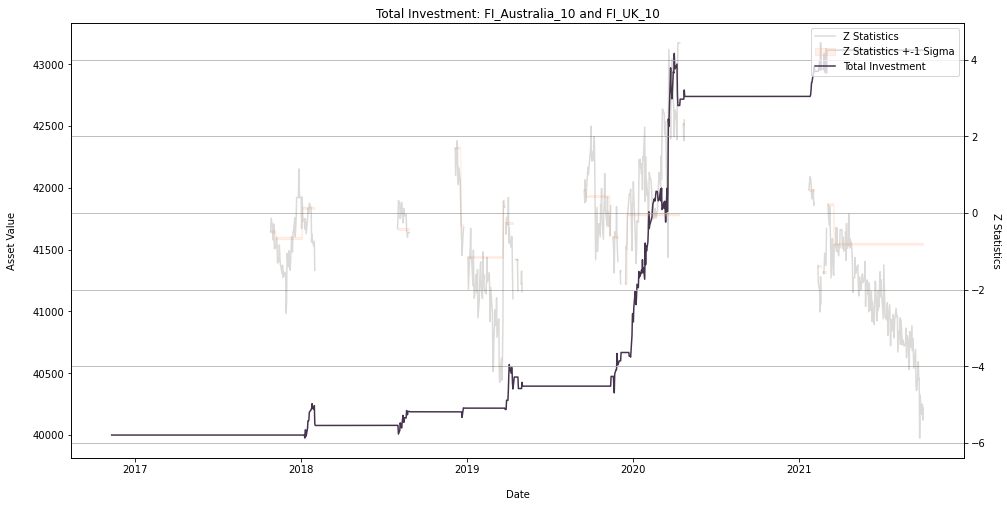

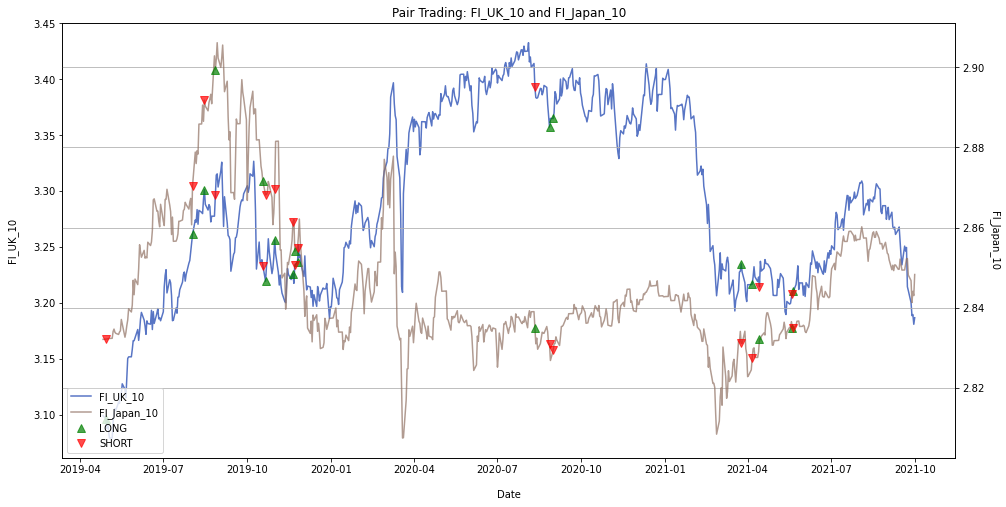

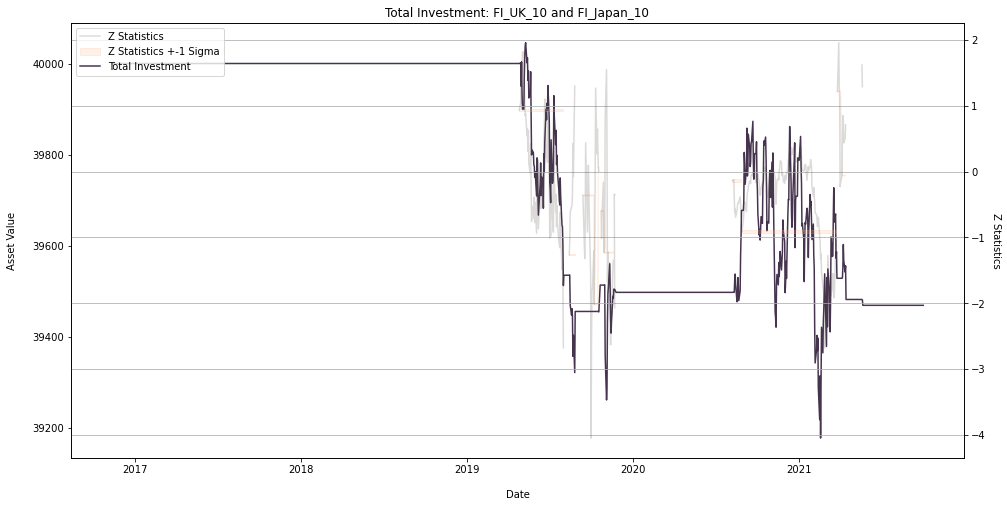

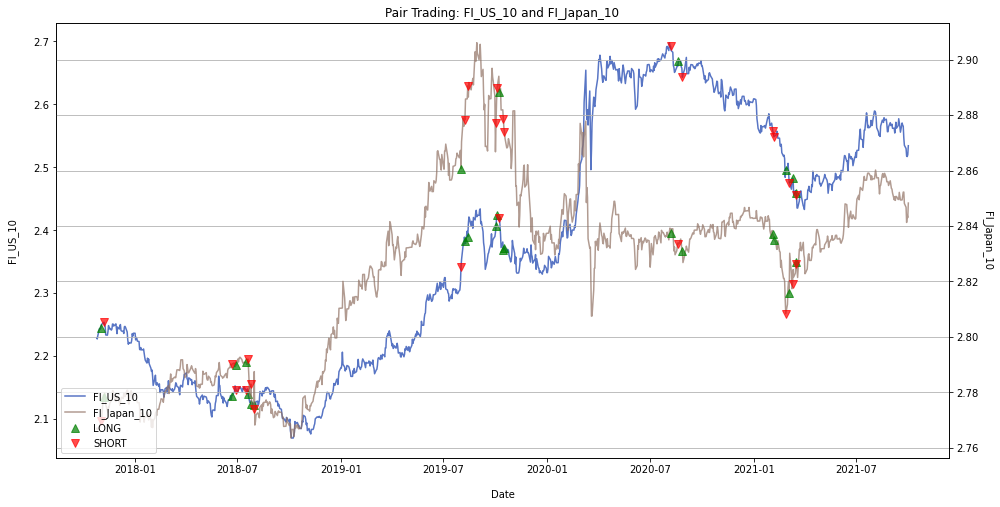

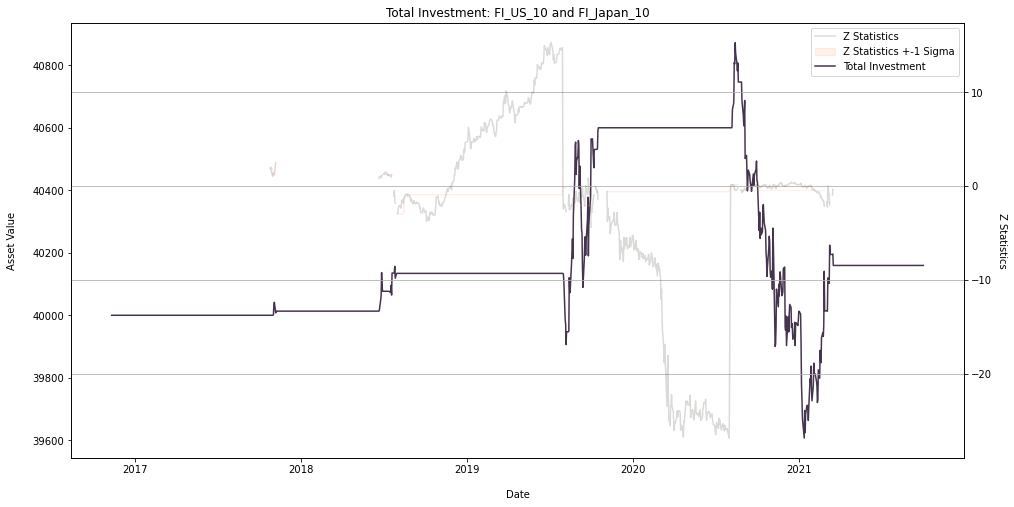

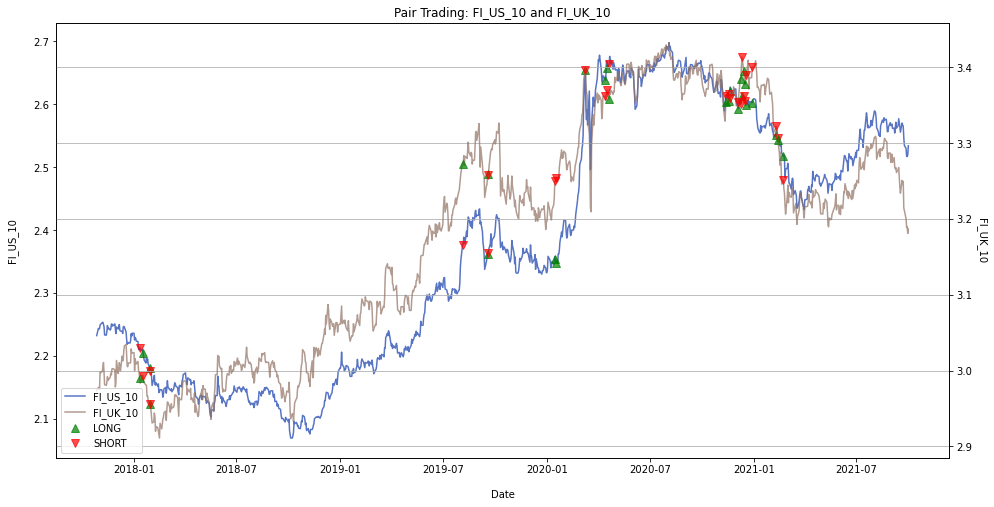

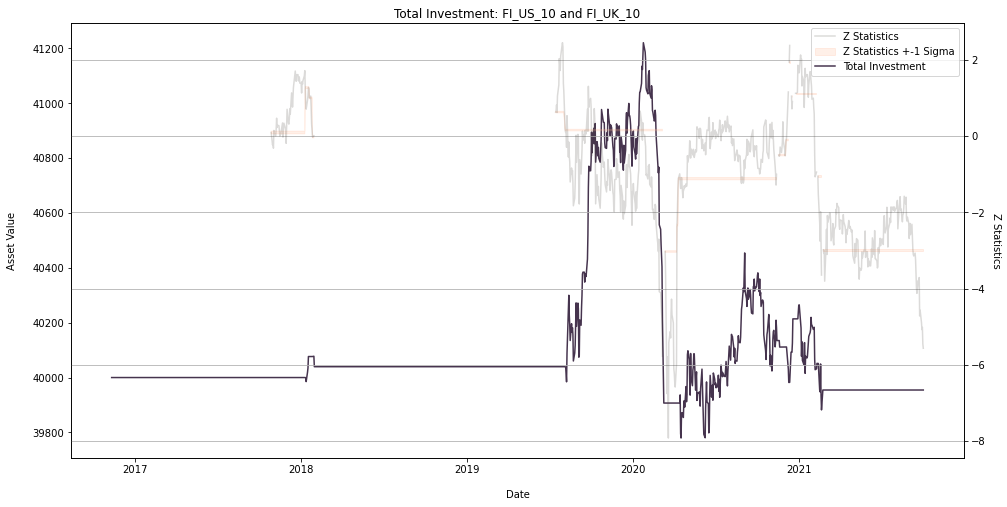

In [26]:
#big_portfolio stores total investment of each pairs in the portfolio
big_portfolio=pd.DataFrame()

#measure_signal stores measure matrix of ech pairs
measure_sigma1 = pd.DataFrame(columns=['Asset 1','Asset 2','ROA','Sharpe Ratio','MDD'])

for (x,y) in all_pairs:
    if __name__ == '__main__':
        m_matrix = main(x,y,sigma=1)
        measure_sigma1 = measure_sigma1.append(m_matrix)
       

Text(0.5, 1.0, 'Portfolio Total Investment (1 sigma)')

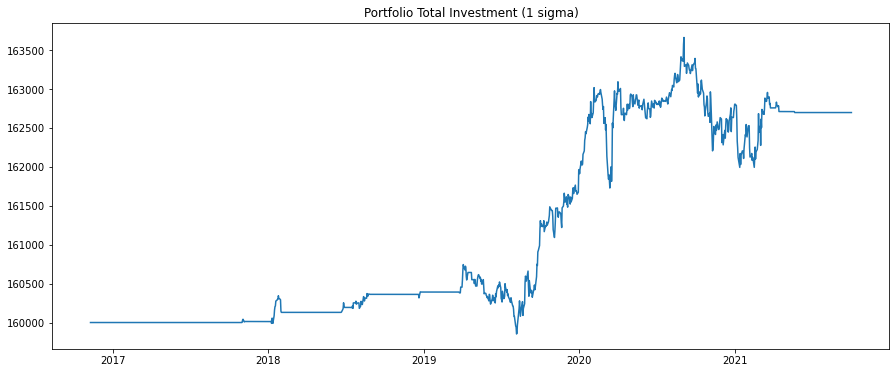

In [27]:
big_portfolio['Portfolio Total Investment'] = big_portfolio.sum(axis = 1)

sigma_df['sigma_1'] = big_portfolio['Portfolio Total Investment']

fig, ax = plt.subplots(figsize=(15, 6),)
ax.plot(big_portfolio.dropna(axis=0,how='any')['Portfolio Total Investment'])
ax.set_title('Portfolio Total Investment (1 sigma)')

### 4.1.2  Two Sigma Testing

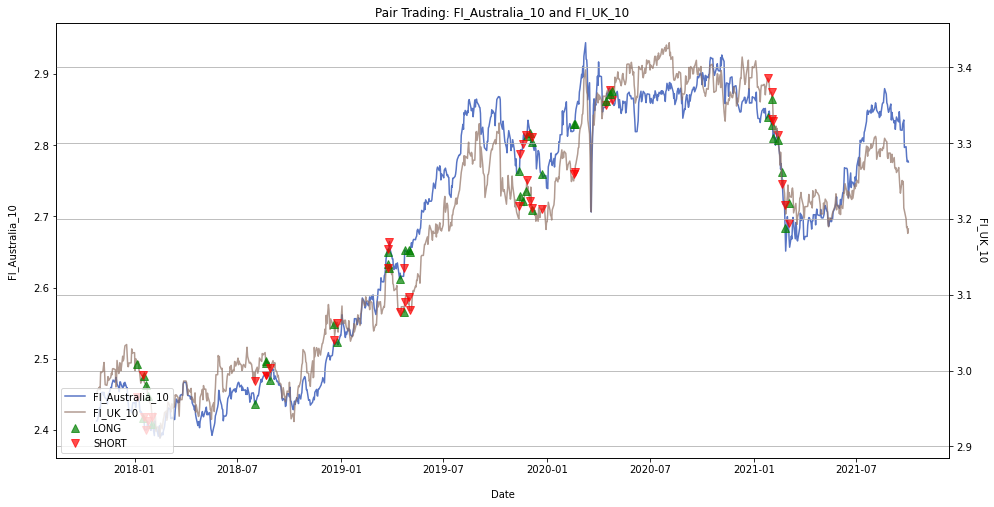

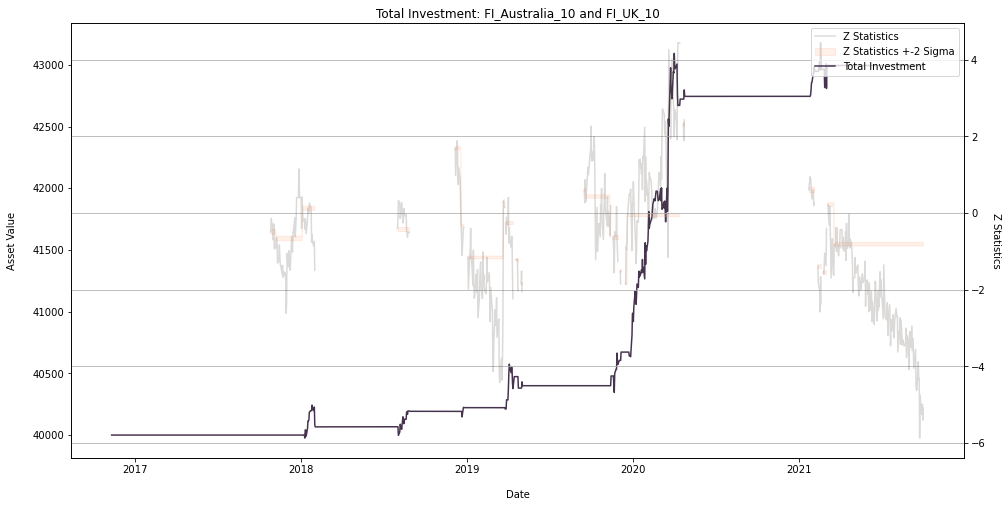

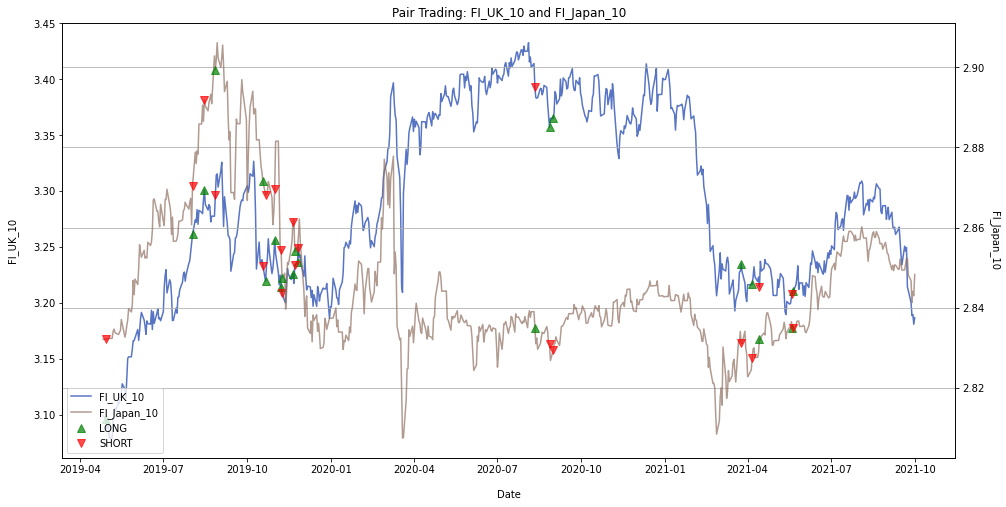

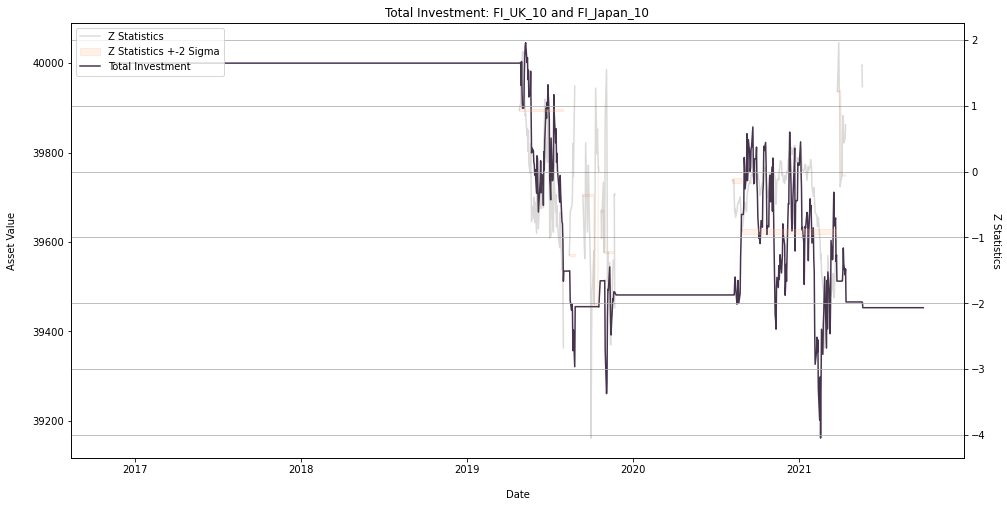

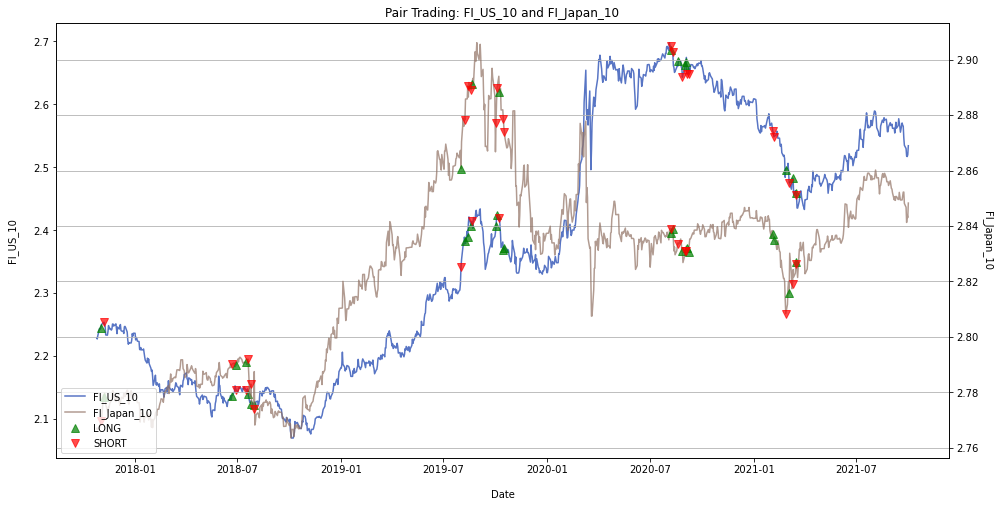

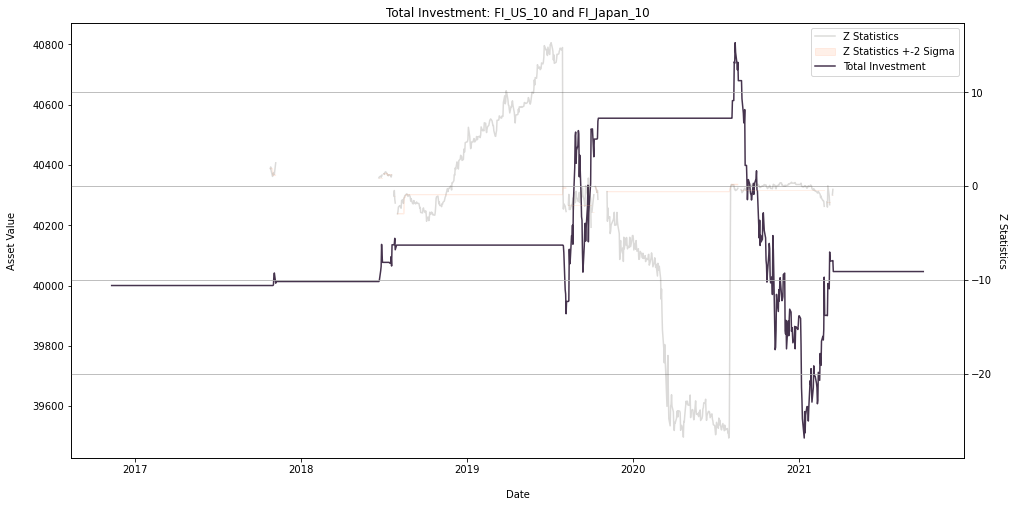

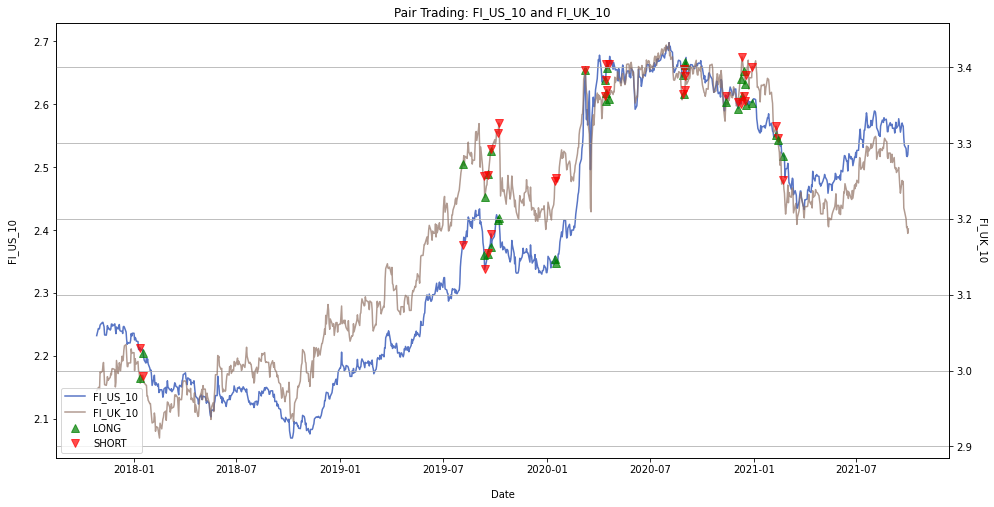

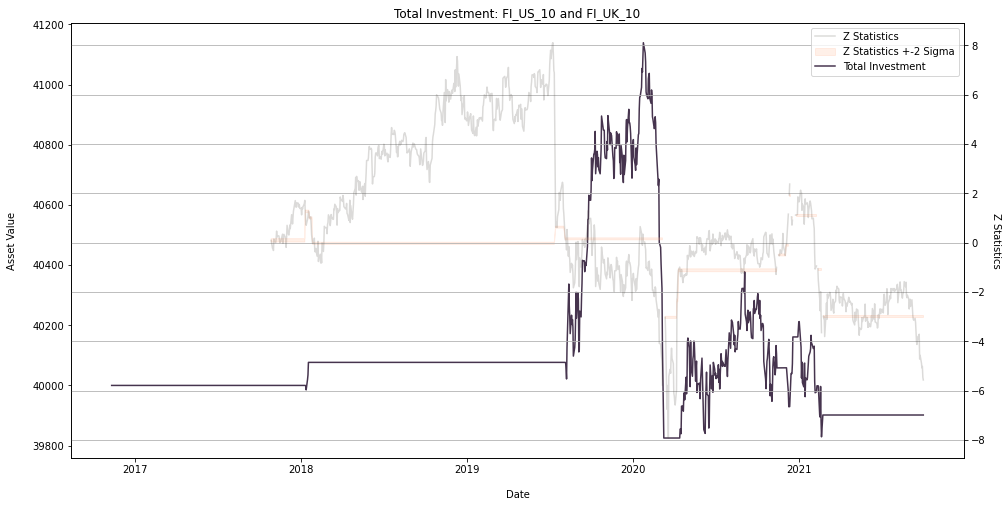

In [28]:
big_portfolio=pd.DataFrame()
measure_sigma2 = pd.DataFrame(columns=['Asset 1','Asset 2','ROA','Sharpe Ratio','MDD'])

for (x,y) in all_pairs:
    if __name__ == '__main__':
        m_matrix = main(x,y,sigma=2)
        measure_sigma2 =  measure_sigma2.append(m_matrix)


big_portfolio['Portfolio Total Investment'] = big_portfolio.sum(axis = 1)
sigma_df['sigma_2'] = big_portfolio['Portfolio Total Investment'] 

Text(0.5, 1.0, 'Portfolio Total Investment (2 sigma)')

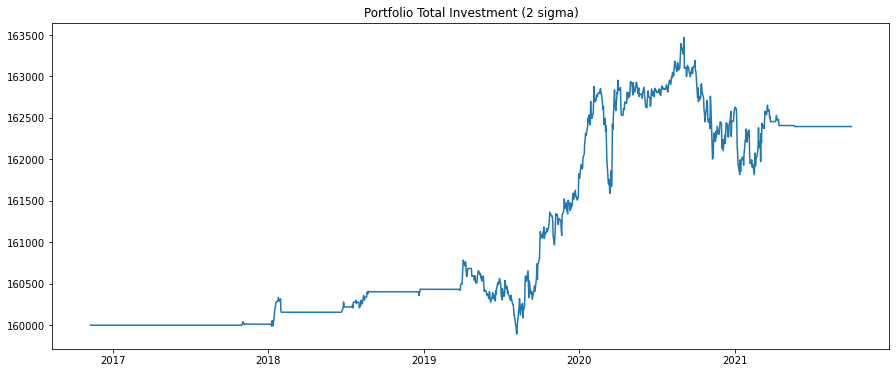

In [29]:
fig, ax = plt.subplots(figsize=(15, 6),)
ax.plot(big_portfolio.dropna(axis=0,how='any')['Portfolio Total Investment'])
ax.set_title('Portfolio Total Investment (2 sigma)')

### 4.1.3  Three Sigma Testing

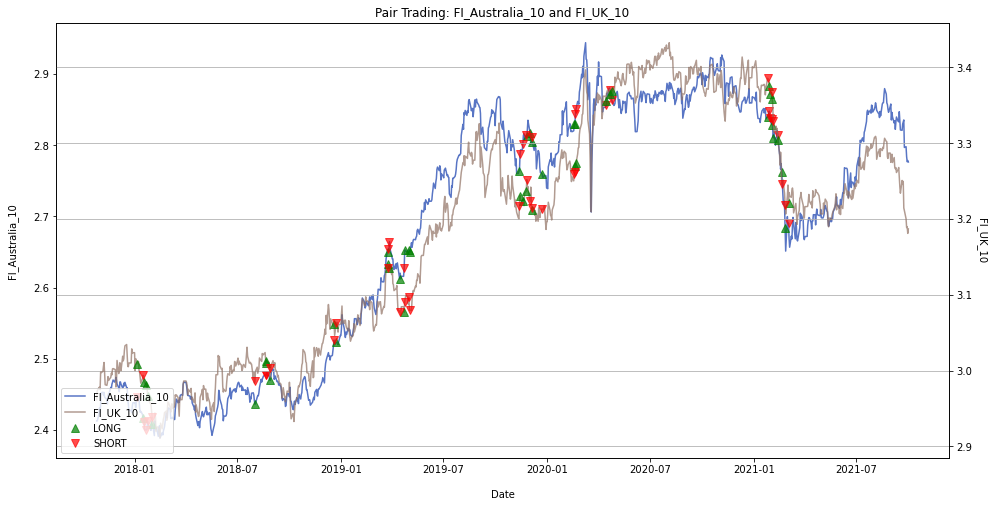

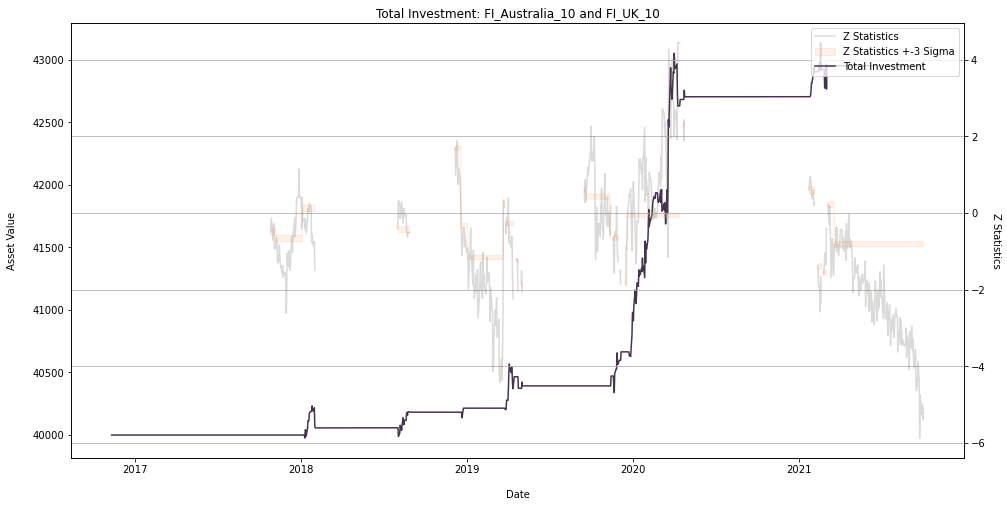

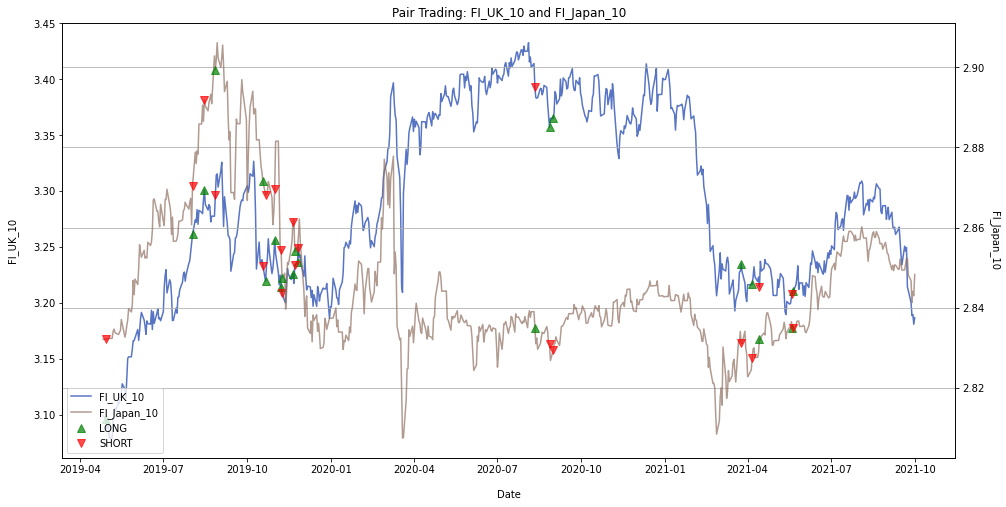

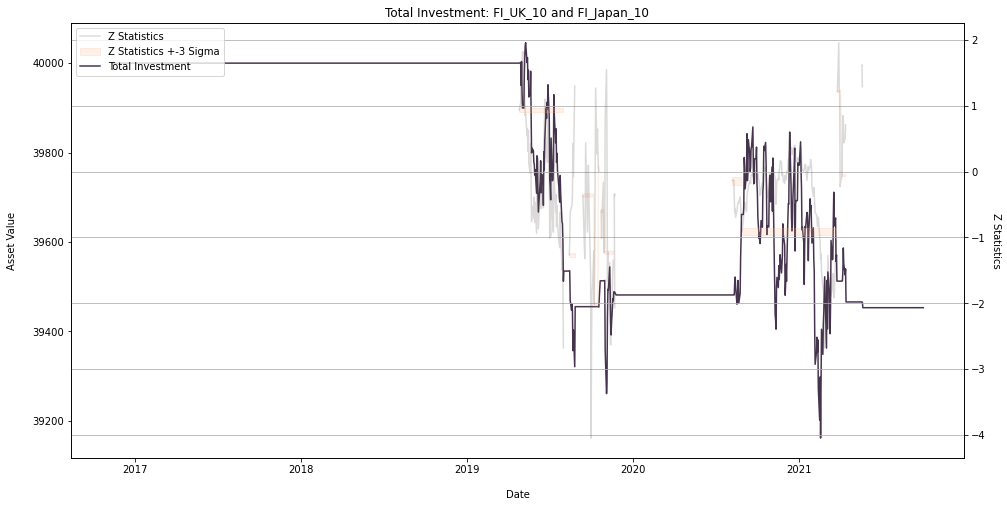

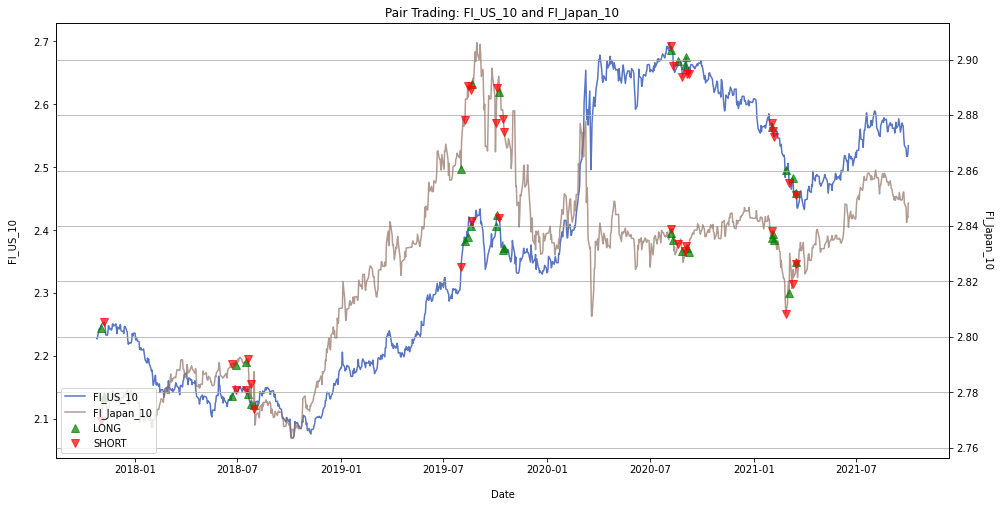

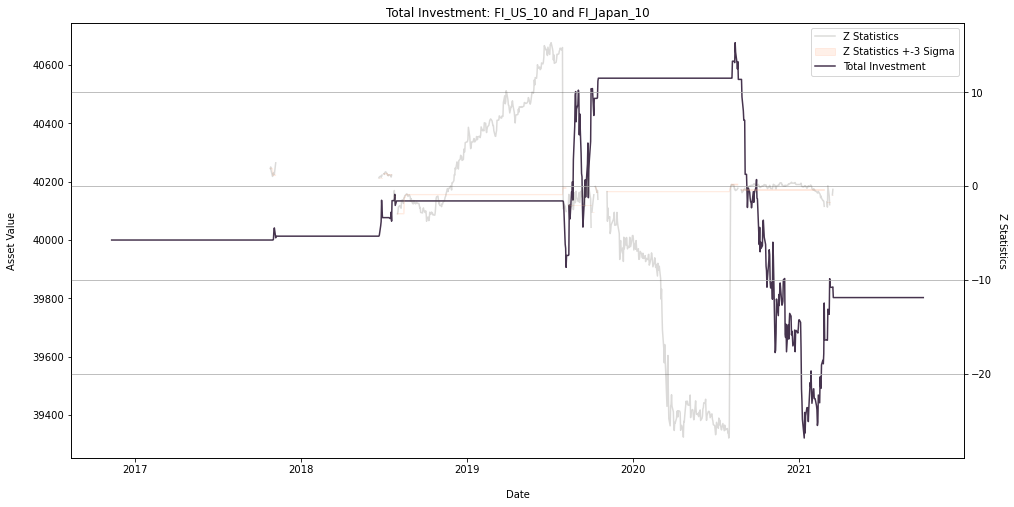

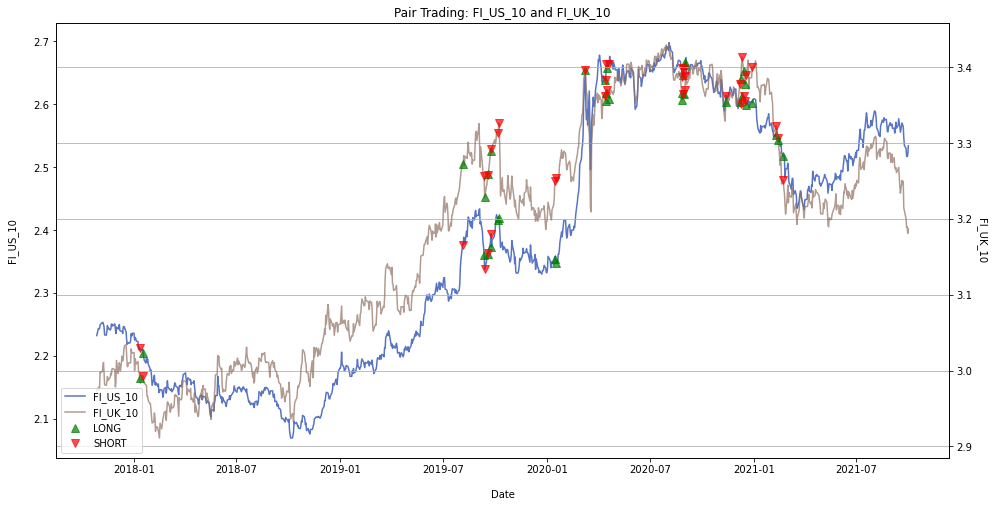

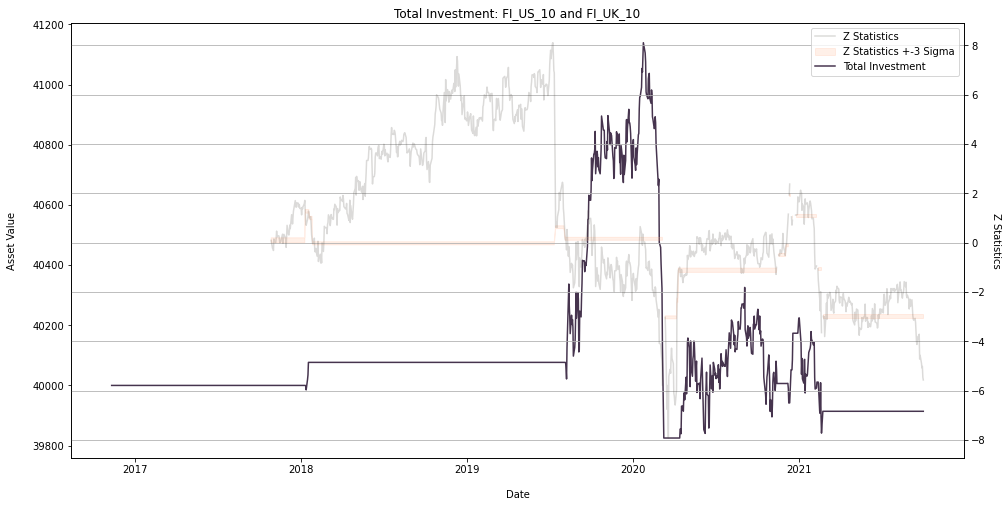

Text(0.5, 1.0, 'Portfolio Total Investment (3 sigma)')

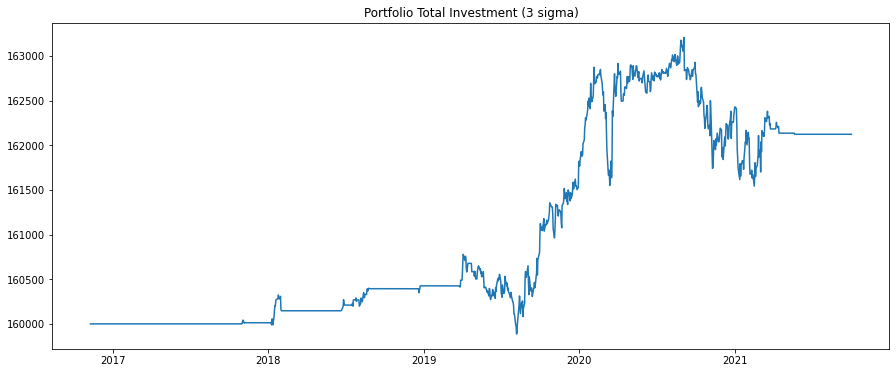

In [30]:
big_portfolio=pd.DataFrame()
measure_sigma3 = pd.DataFrame(columns=['Asset 1','Asset 2','ROA','Sharpe Ratio','MDD'])

for (x,y) in all_pairs:
    if __name__ == '__main__':
        m_matrix = main(x,y,sigma=3)
        measure_sigma3 = measure_sigma3.append(m_matrix)

big_portfolio['Portfolio Total Investment'] = big_portfolio.sum(axis = 1)
sigma_df['sigma_3']=big_portfolio['Portfolio Total Investment'].dropna(axis=0,how='any')

#plot totl investment when sigma = 3
fig, ax = plt.subplots(figsize=(15, 6))
ax.plot(big_portfolio.dropna(axis=0,how='any')['Portfolio Total Investment'])
ax.set_title('Portfolio Total Investment (3 sigma)')

<AxesSubplot:title={'center':'Total Investment against Different Sigma'}, xlabel='Date'>

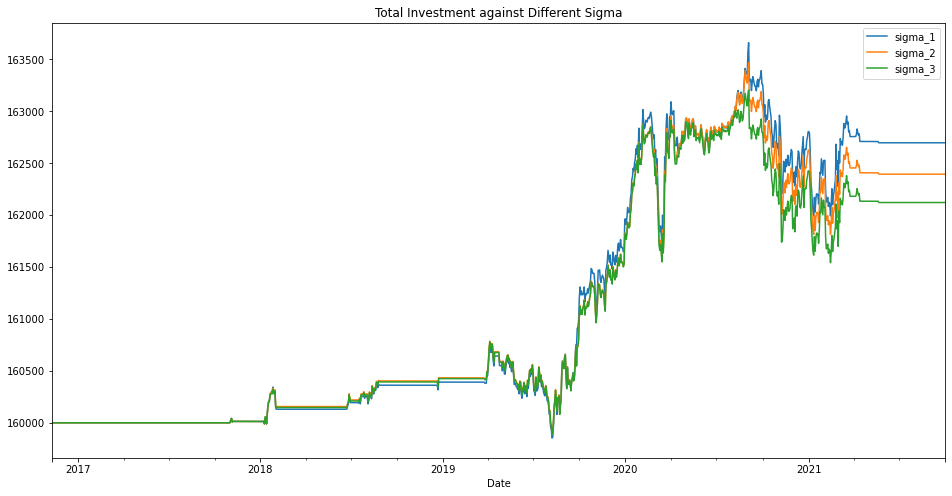

In [31]:
# plot total investment against different sigma
sigma_df[1:].plot(figsize=(16,8),title='Total Investment against Different Sigma')

## 4.2 Risk Ratios

Below are three performance indicators that are taken into account

1. Shape Ratio = (Rp-Rf)/σp

The Sharpe ratio is used to help investors understand the return of an investment
compared to its risk. The ratio is the average return earned in excess of the risk-free
rate per unit of volatility or total risk.

where Rp denotes the return of the portfolio, Rf denotes the risk-free rate and σp denotes the standard deviation of the portfolio’s excess return.
In the given universe, assume FI_US is risk-free.

2. ROA = (End Value-Initial Value)/Initial Value


3. Maximum Draw Down (MDD) = (TV-PV)/PV

where T V denotes the trough value and P V denotes the peak value.


In [32]:
measure_sigma1.mean()

ROA                0.015404
Sharpe Ratio       0.331289
MDD             1693.702086
dtype: float64

In [33]:
measure_sigma2.mean()

ROA                0.013618
Sharpe Ratio       0.329503
MDD             1678.395141
dtype: float64

In [34]:
measure_sigma3.mean()

ROA                0.011939
Sharpe Ratio       0.327824
MDD             1678.992424
dtype: float64

The current algorithm performs best when sigma = 1, and the ROA and Sharpe ratio are the highest. MDD ranges from 1678 to 1693 and accounts for roughly 1% of capital. While the backtesting is low risk and low return, we can adjust the size of each trade to use the capital more effectively. This is determined by the portfolio's risk tolerance and the expected rate of return.

## 4.3 Risk from macro events

While there is a long-run correlation between different fixed-income assets, there are times this correlation broke down.
For instance, between 2018-2019, Australia fixed income and UK fixed income decoupled, which dissolved the positive correlation relationship between the two assets. Therefore, close monitoring of unexpected news is essential to determine the trading rule.